Reanalyze Helewell data relative to symtpom onset

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import datetime as dt
import pymc3 as pm

In [3]:
sympt = pd.read_csv('~/Documents/Github/pcr-profile/symptom_data.csv')
test = pd.read_csv('~/Documents/Github/pcr-profile/test_data.csv')
sympt
symponset = 4.8

In [4]:
ids = np.unique(sympt['num_id'])
sympt['day_no'] = np.zeros(len(sympt),dtype=np.int)
for i in np.arange(len(sympt)):
    dh = dt.datetime.strptime(sympt['date'][i],'%Y-%m-%d')
    td = dh - dt.datetime.strptime('2020-01-01','%Y-%m-%d')
    sympt.loc[i,'day_no'] = td.days

test['day_no'] = np.zeros(len(test),dtype=np.int)
for i in np.arange(len(test)):
    dh = dt.datetime.strptime(test['date'][i],'%Y-%m-%d')
    td = dh - dt.datetime.strptime('2020-01-01','%Y-%m-%d')
    test.loc[i,'day_no'] = td.days
    
first_day = np.min(test['day_no'].to_numpy())
last_day = np.max(test['day_no'].to_numpy())

In [5]:
symptids = np.array([],dtype=np.int)
for i in ids:
    if np.any(sympt['symptom'][sympt['num_id'] == i]):
        symptids = np.append(symptids,i)

sympt_lb = np.zeros(len(symptids),dtype=np.int)
sympt_ub = np.zeros(len(symptids),dtype=np.int)
test_lb = np.zeros(len(symptids),dtype=np.int)
test_ub = np.zeros(len(symptids),dtype=np.int)

test_days = np.zeros(len(symptids),dtype=np.object)
test_results = np.zeros(len(symptids),dtype=np.object)
total_tests = 0
for i in symptids:
    s = sympt['symptom'][sympt['num_id'] == i].to_numpy()
    d = sympt['day_no'][sympt['num_id'] == i].to_numpy()
    n = np.arange(len(s))
    nh = n[s][0]
    sympt_lb[i-1] = d[nh-1]
    sympt_ub[i-1] = d[nh]
    
    dtest = test['day_no'][test['num_id'] == i].to_numpy()
    t = test['pcr_result'][test['num_id'] == i].to_numpy()
    n = np.arange(len(t))
    if np.any(t > 0):
        nh = n[t][0]
        if nh > 0:
            test_lb[i-1] = dtest[nh-1]
        else:
            test_lb[i-1] = first_day
        
        nh = n[t][-1]
        if nh < len(dtest)-1:
            test_ub[i-1] = dtest[nh+1]
        else:
            test_ub[i-1] = last_day
    else:
        test_lb[i-1] = first_day
        test_ub[i-1] = last_day
    
    #could put extra tests in at start day
    #test_days[i-1] = np.append(np.array([first_day-1]),dtest)
    #test_results[i-1] = np.append(np.array([False]),t)
    
    test_days[i-1] = dtest
    test_results[i-1] = t
    
    total_tests += len(test_days[i-1])


All symptomatic

For each individual, define test times



In [6]:
X = np.zeros(total_tests)
Y = np.zeros(total_tests,dtype=np.bool)
Z = np.zeros(total_tests)
jcount = 0
for i in np.arange(len(symptids)):
    X[jcount:(jcount + len(test_days[i]))] = test_days[i]
    Y[jcount:(jcount + len(test_days[i]))] = test_results[i]
    Z[jcount:(jcount + len(test_days[i]))] = 0.5 * (sympt_lb[i] + sympt_ub[i])
    jcount += len(test_days[i])


In [19]:
import theano
import theano.tensor as tt

test_model = pm.Model()
Nsamples = 1000
with test_model:    
    ptimes = tt.zeros(len(symptids))
    for i in np.arange(len(symptids)):
        ptimes = tt.set_subtensor(ptimes[i],pm.Normal('tpost%d'%i, mu=test_lb[i], sigma=3.0))

    # Priors for unknown model parameters
    BoundedNormalLow = pm.Bound(pm.Normal, upper=0)
    BoundedNormalUpp = pm.Bound(pm.Normal, lower=0)
    pduration = BoundedNormalUpp('tau', mu = 5.0, sigma = 5.0)
    sens = pm.Uniform('sens', lower=0, upper=1) 
    beta1 =  BoundedNormalUpp('beta1', mu = 0.1, sigma = 1.0)
    beta2 =  BoundedNormalLow('beta2', mu = -0.1, sigma = 1.0)
    
    pt = tt.zeros(total_tests)
    jcount = 0
    for i in np.arange(len(symptids)):
        if len(test_days[i]) > 0: 
            pt = tt.set_subtensor(pt[jcount:(jcount + len(test_days[i]))], ptimes[i])            
        jcount += len(test_days[i])
                      
    rate1 = pm.math.switch((X - pt < 0), beta1, 0)
    rate2 = pm.math.switch((X - pt - pduration > 0), beta2, 0)                     
    muh = sens * pm.math.exp(rate1*(X - pt)) * pm.math.exp(rate2*(X - pt - pduration))
    Y_obs = pm.Bernoulli("Y_obs", p = muh, observed=Y)
    
    param_samples = pm.sample(Nsamples, init='adapt_diag', tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, sens, tau, tpost26, tpost25, tpost24, tpost23, tpost22, tpost21, tpost20, tpost19, tpost18, tpost17, tpost16, tpost15, tpost14, tpost13, tpost12, tpost11, tpost10, tpost9, tpost8, tpost7, tpost6, tpost5, tpost4, tpost3, tpost2, tpost1, tpost0]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [01:18<00:00, 101.77draws/s]


(0, 1.0)

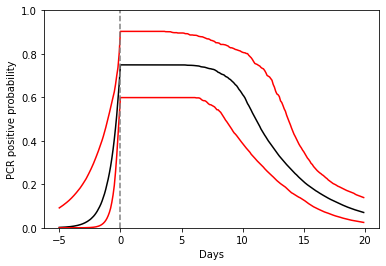

In [20]:
ndrange = np.arange(-5,20,0.1)
traces = np.zeros((len(ndrange), Nsamples))
for i in np.arange(Nsamples):
    Xh = ndrange 
    traces[:,i] = param_samples['sens'][i]
    traces[(Xh < 0),i] = param_samples['sens'][i] * np.exp(param_samples['beta1'][i]*Xh[Xh < 0])
    Xh1cond = (Xh > param_samples['tau'][i])
    traces[Xh1cond,i] = param_samples['sens'][i] * np.exp(param_samples['beta2'][i]*(Xh[Xh1cond]-param_samples['tau'][i]))            
plt.plot(ndrange, np.median(traces,1),c='k')
plt.plot(ndrange, np.quantile(traces,0.975,1),c='r')
plt.plot(ndrange, np.quantile(traces,0.025,1),c='r')
plt.plot([0,0],[0,1],'--',c=[0.5,0.5,0.5])
plt.xlabel('Days')
plt.ylabel('PCR positive probability')
plt.ylim(0,1.0)

(array([  1.,   2.,   2.,   1.,   0.,   2.,   3.,   2.,   0.,   3.,   2.,
          5.,   3.,   4.,   2.,   2.,   3.,   5.,   7.,  17.,  15.,  14.,
          9.,  16.,  22.,  22.,  30.,  15.,  11.,  19.,  27.,  22.,  12.,
         12.,  17.,  24.,  26.,  34.,  30.,  62.,  58., 132., 159., 213.,
        275., 230., 185., 177., 128.,  69.,  49.,  54.,  50.,  49.,  53.,
         60.,  63.,  52.,  66.,  75.,  85.,  69.,  49.,  32.,  25.,  16.,
          5.,   7.,   7.,  29.,  21.,  13.,   2.,   9.,   8.,   5.,  23.,
         35.,  51.,  50.,  35.,  29.,  26.,  31.,  33.,  47.,  57.,  65.,
         47.,  51.,  57.,  62.,  71.,  42.,  26.,  29.,  21.,   9.,  16.,
          3.]),
 array([0.65205739, 0.65439202, 0.65672665, 0.65906128, 0.66139591,
        0.66373055, 0.66606518, 0.66839981, 0.67073444, 0.67306907,
        0.6754037 , 0.67773833, 0.68007296, 0.68240759, 0.68474222,
        0.68707685, 0.68941148, 0.69174611, 0.69408074, 0.69641537,
        0.69875001, 0.70108464, 0.70341927, 0.

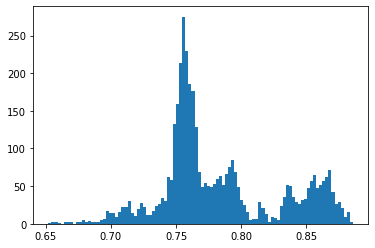

In [54]:
plt.hist(param_samples['sens'],bins=100)

In [55]:
import seaborn as sns

ids = np.zeros(Nsamples*len(symptids),dtype=np.int)
sotime = np.zeros(Nsamples*len(symptids))
speriod = np.zeros(Nsamples*len(symptids))
for n in np.arange(Nsamples):
    for j in np.arange(len(symptids)):
        ids[n*len(symptids) + j] = symptids[j]
        sotime[n*len(symptids) + j] = param_samples['tpost%d'%j][n]
        
dicth = {'ids':ids, 'peaktime':sotime}
df = pd.DataFrame(dicth)

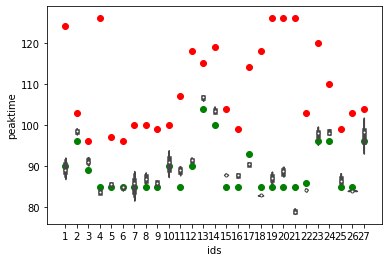

In [58]:
sns.violinplot(x='ids',y='peaktime',data=df)
plt.scatter(symptids-1, test_lb, c='g')
plt.scatter(symptids-1, test_ub, c='r')

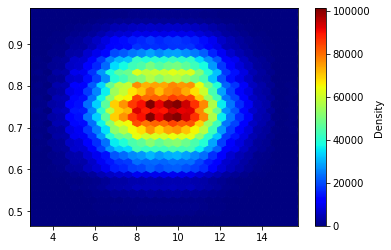

In [34]:
from matplotlib import cm

x, y = param_samples['tau'], param_samples['sens']
X, Y = np.meshgrid(x,y)

x = X.ravel()
y = Y.ravel()
gridsize=30
plt.subplot(111)

# if 'bins=None', then color of each hexagon corresponds directly to its count
# 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# the result is a pure 2D histogram 

plt.hexbin(x, y, gridsize=gridsize, cmap=cm.jet, bins=None)
plt.axis([x.min(), x.max(), y.min(), y.max()])

cb = plt.colorbar()
cb.set_label('Density')
plt.show()   